In [1]:
import sys 
sys.path.append('../')

import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import load_mat1d
from src.ops import grid2d_coords
from src.green_net import Grid1D

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Shallow(nn.Module):
    def __init__(self, in_dim , h_dim , out_dim):
        super().__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

def count_parameters(model, requires_grad = True):
    """Count trainable parameters for a nn.Module."""
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

In [4]:
def loss(model, grid, F, U):
    nh = grid.nh
    h = grid.nh
    G = model(grid.x_hh).reshape(nh, nh)
    U_pred = h*G @ F
    loss = torch.mean((U-U_pred)**2)
    return loss

In [5]:
F_train = load_mat1d('../dataset/f1d_513_3.00e-02.mat', 'F', 100, True)
U_train = load_mat1d('../dataset/logarithm_513_3.00e-02.mat', 'U', 100, True)
F_val = load_mat1d('../dataset/f1d_513_3.00e-02.mat', 'F', 100, False)
U_val = load_mat1d('../dataset/logarithm_513_3.00e-02.mat', 'U', 100, False)

F_train = torch.from_numpy(F_train).float().to(device)
U_train = torch.from_numpy(U_train).float().to(device)
F_val = torch.from_numpy(F_val).float().to(device)
U_val = torch.from_numpy(U_val).float().to(device)

grid = Grid1D(513, device)
grid.init_grid_hh()

In [6]:
model = Shallow(2, 50, 1).to(device)

In [7]:
Adam_iter = 100000 # stop when iter > Adam_iter
update_lr_1 = 30000  # change adam lr from 0.01 to 0.001 at update_lr_1 iteration
update_lr_2 = 50000  # change adam lr from 0.001 to 0.0001 at update_lr_2 iteration

optimizerAdam = torch.optim.Adam(
    model.parameters(), 
    lr=0.01
)

In [8]:
itera = 0

savedloss = []
savedloss_valid = []

In [9]:
model.train()
for step in range(Adam_iter+1):
    if step == update_lr_1:
        print('change learning rate to 0.001')
        for g in optimizerAdam.param_groups:
            g['lr'] = 0.001
    if step == update_lr_2:
        print('change learning rate to 0.0001')
        for g in optimizerAdam.param_groups:
            g['lr'] = 0.0001
              
    # Backward and optimize
    optimizerAdam.zero_grad()

    lossAdam = loss(model, grid, F_train, U_train)
    lossAdam_valid = loss(model, grid, F_val, U_val)
    
    if step % 5000 == 0:
        print('Iter %d, LossAdam: %.5e' % (itera, lossAdam.item()))

    savedloss.append(lossAdam.item())
    savedloss_valid.append(lossAdam_valid.item())
    lossAdam.backward(retain_graph = True)
        
    if step == Adam_iter:
        break

    optimizerAdam.step()
    itera += 1

Iter 0, LossAdam: 3.32227e+08
Iter 5000, LossAdam: 4.42911e+04
Iter 10000, LossAdam: 4.76011e+00
Iter 15000, LossAdam: 4.84235e+00
Iter 20000, LossAdam: 5.88436e+00
Iter 25000, LossAdam: 2.95433e+01
change learning rate to 0.001
Iter 30000, LossAdam: 3.39137e+00
Iter 35000, LossAdam: 6.51565e-01
Iter 40000, LossAdam: 1.73318e+00
Iter 45000, LossAdam: 3.75837e-01
change learning rate to 0.0001
Iter 50000, LossAdam: 1.55019e-01
Iter 55000, LossAdam: 1.50719e-01
Iter 60000, LossAdam: 1.58780e-01
Iter 65000, LossAdam: 5.44581e-01
Iter 70000, LossAdam: 2.34803e+00
Iter 75000, LossAdam: 1.47817e-01
Iter 80000, LossAdam: 1.19258e+00
Iter 85000, LossAdam: 1.47096e-01
Iter 90000, LossAdam: 1.46994e-01
Iter 95000, LossAdam: 1.46290e-01
Iter 100000, LossAdam: 1.45894e-01


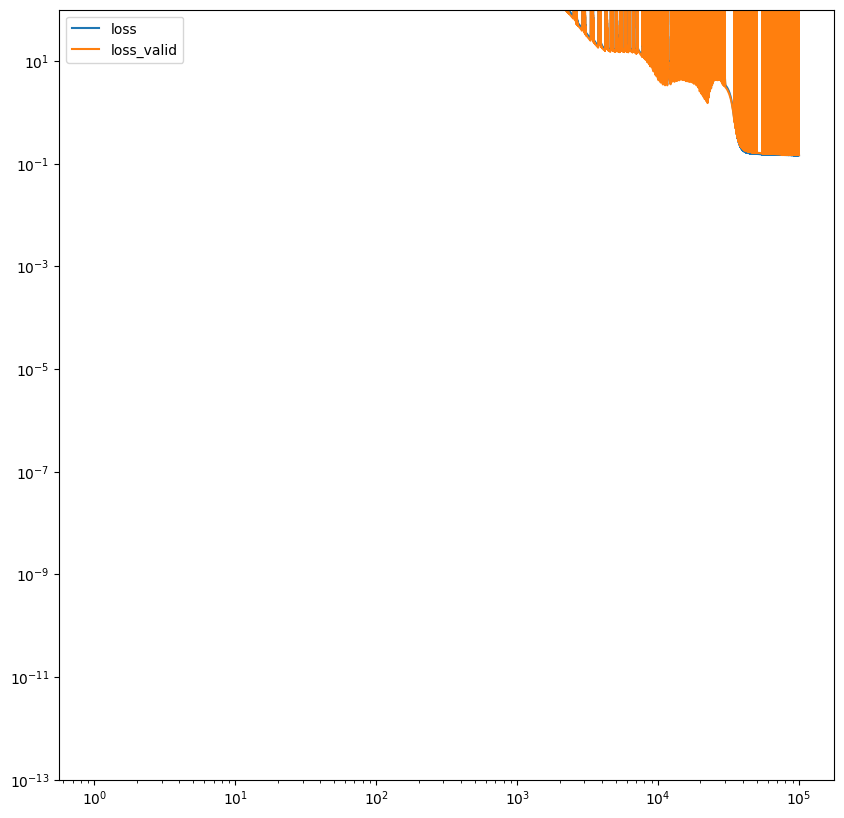

In [11]:
start = 0
end = itera
idx = list(range(start, end, 1))

fig = plt.figure(figsize= (10, 10))
plt.ylim(10**(-13), 10**(2))
plt.yscale("log")
plt.xscale("log")
plt.plot(idx, savedloss[start:end], label = "loss")
plt.plot(idx, savedloss_valid[start:end], label = "loss_valid")
plt.legend()
plt.show()